## Some visualisation on presets values

In [1]:
import os

import numpy as np
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib widget
from IPython.display import Audio

from synth import dexed



In [2]:
dexed_renderer = dexed.Dexed()
dexed_preset_db = dexed.PresetDatabase()
dexed_renderer.set_preset_db(dexed_preset_db)
# Visu du dataframe de départ
dexed_renderer.preset_db._all_presets_df

,index_preset,index_cart,index_in_cartridge,name,pickled_params_np_array,other_names
0,0,0,0,BRITE RDS,"[1.0, 0.0, 1.0, 0.5, 0.129032, 0.857143, 0.0, ...",None
1,1,0,1,BRITE.FULL,"[1.0, 0.0, 1.0, 0.5, 0.129032, 1.0, 0.0, 0.313...",None
2,2,0,2,BRITE-FULL,"[1.0, 0.0, 1.0, 0.5, 0.129032, 1.0, 0.0, 0.313...",None
3,3,0,3,BRKN WNGS1,"[1.0, 0.0, 1.0, 0.5, 0.064516, 1.0, 1.0, 0.242...",None
4,4,0,4,BROKEROADS,"[1.0, 0.0, 1.0, 0.5, 0.16129, 0.857143, 0.0, 0...",None
...,...,...,...,...,...,...
30757,393869,12529,18,Hair-kr MS,"[1.0, 0.0, 1.0, 0.5, 0.483871, 1.0, 1.0, 0.111...",None
30758,393870,12529,19,DreamySyn,"[1.0, 0.0, 1.0, 0.5, 0.806452, 1.0, 1.0, 0.252...",None
30759,393874,12529,23,timbali,"[1.0, 0.0, 1.0, 0.5, 0.483871, 1.0, 1.0, 0.111...",None
30760,393876,12529,25,PIES GLOCK,"[1.0, 0.0, 1.0, 0.5, 0.193548, 1.0, 1.0, 0.343...",None


In [3]:
# Histogrammes de *tous* les paramètres, pour voir ceux qu'on peut éventuellement virer
param_names = dexed_preset_db.get_param_names()
presets_mat = dexed_preset_db._presets_mat
n_cols = 6
n_rows = 1 + presets_mat.shape[1] // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(9, n_rows * 1.0), sharex=True)
for i in range(presets_mat.shape[1]):
    param_values = presets_mat[:, i]
    col = i % n_cols
    row = i // n_cols
    # Custom bins for discrete params
    param_cardinality = dexed_renderer.get_param_cardinality(i)
    if param_cardinality > 0:
        bins = [float(i) / param_cardinality for i in range(param_cardinality+1)]
    else:
        bins = 50
    axes[row, col].hist(param_values, bins=bins)
    axes[row, col].set_xlim([-0.1, 1.1])
    axes[row, col].set_title("{} {}".format(i, param_names[i]), fontsize=8)
del bins, n_cols, n_rows, i, col, row, param_cardinality
fig.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Remarques sur les paramètres
* 13 transpose (middle C) devrait rester à sa valeur centrale. Pas besoin d'aller perturber tout le pitch
* 0, 1, 2, 3 (params généraux de filtre de volume) peuvent aussi toujours rester à leurs valeur de défaut
* Les OP Switch sont toujours à ON

OP1 est OFF pour 0 preset(s)
OP2 est OFF pour 0 preset(s)
OP3 est OFF pour 0 preset(s)
OP4 est OFF pour 0 preset(s)
OP5 est OFF pour 0 preset(s)
OP6 est OFF pour 0 preset(s)


Text(0.5, 1.0, "Histogramme des algorithmes utilisés pour l'ensemble des presets")

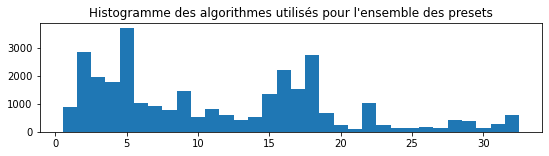

In [4]:
# Infos sur les paramètres potentiellement inutilisés
for i in range(6):  # synthés qui ont 1 des 6 oscillateurs éteint ?
    opx_switch_values = presets_mat[:, 44 + 22 * i]
    print("OP{} est OFF pour {} preset(s)".format(i+1, opx_switch_values[np.where(opx_switch_values < 0.5)].shape[0]))

# Répartition des algorithmes
preset_algos = presets_mat[:, 4]
preset_algos = np.asarray(np.round(1.0 + preset_algos * 31.0), dtype=np.int)
fig, ax = plt.subplots(1, 1, figsize=(9, 2))
ax.hist(preset_algos, bins=[0.5 + i for i in range(33)])
_ = ax.set_title("Histogramme des algorithmes utilisés pour l'ensemble des presets")


## Dexed-generated wav file


In [8]:
# Nouvelle instance de dx7 à chaque nouveau rendu (pour éviter hanging notes...)

dexed_renderer = dexed.Dexed()
dexed_renderer.set_preset_db(dexed_preset_db)

preset_indexes = dexed_preset_db.get_preset_indexes_for_algorithm(5)

idx = preset_indexes[663]
dexed_renderer.assign_preset_from_db(idx)
dexed_renderer.set_default_general_filter_and_tune_params()
dexed_renderer.prevent_SH_LFO()
dexed_renderer.render_note(60, 100, filename="Test.wav")  # 60: . 32: E3
#print(dexed_renderer.current_preset[12])
    
# TODO création auto avec widget....
    
# Juste une lecture audio générée par remote PyCharm pour l'instant
Fs, audio = wavfile.read("Test.wav")
t = np.linspace(0.0, len(audio)/Fs, num=len(audio), endpoint=True)
fig, ax = plt.subplots(1, 1, figsize=(9, 2))
ax.plot(t, audio)
ax.set_title("Preset {} '{}'".format(idx, dexed_preset_db.get_preset_name(idx)))
Audio("Test.wav")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …